In [1]:
import os
import sys
sys.path.append("C:\\Users\\"+os.getlogin()+"\\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\\PainClassifier")
from my_data_generator import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import h5py
import warnings
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from datetime import datetime
import scipy as sp
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv3D, MaxPooling3D, Flatten, Dropout, GlobalAveragePooling3D, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from keras.regularizers import l2
import cv2
from keras import initializers
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
import tensorflow as tf
from keras import losses

In [3]:
def confusionmatrix_multiclass(y_test,pred):
    cm = confusion_matrix(y_test, (np.rint(preds)).astype(int) )
    group_names = ['True baseline','False Baseline','False Baseline',   
                   'False week 1','Truec','False Week 1',
                  'False week 7','False week 7','True week 7']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         np.ndarray.flatten(cm/(np.sum(cm,axis=1).reshape(3,1)))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['Baseline','Week 1','Week 7'] ,yticklabels = ['Baseline','Week 1','Week 7'])
    plt.show()

def confusionmatrix(y_test,pred):
    #Construct the Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    group_names = ['True Male','False Female','False Male','True Female']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         np.ndarray.flatten(cm/(np.sum(cm,axis=1).reshape(2,1)))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['MALE','FEMALE'] ,yticklabels = ['MALE','FEMALE'])
    plt.show()
    
def confusionmatrix_binary(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    group_names = ['True baseline','False baseline','False Week 1','True Week 1']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         np.ndarray.flatten(cm/(np.sum(cm,axis=1).reshape(2,1)))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['MALE','FEMALE'] ,yticklabels = ['MALE','FEMALE'])
    plt.show()

def ROC(probs,y_test): #binary
    #Classification Area under curve
     warnings.filterwarnings('ignore')
             
     auc = roc_auc_score(y_test, probs)
     print('AUC - Test Set: %.2f%%' % (auc*100))
    
     # calculate roc curve
     fpr, tpr, thresholds = roc_curve(y_test, probs)
     # plot no skill
     plt.plot([0, 1], [0, 1], linestyle='--')
     # plot the roc curve for the model
     plt.plot(fpr, tpr, marker='.')
     plt.xlabel('False positive rate')
     plt.ylabel('Sensitivity/ Recall')
     # show the plot
     plt.show()
    
     probs = (np.rint(probs)).astype(int)   
        
     precision = precision_score(y_test, probs)
     print('Precision: %f' % precision)
     # recall: tp / (tp + fn)
     recall = recall_score(y_test, probs)
     print('Recall: %f' % recall)
     # f1: tp / (tp + fp + fn)
     f1 = f1_score(y_test, probs)
     print('F1 score: %f' % f1)
        
def ROC_multiclass(model, y_test, n_class):
    #y_test: array size (# of subjects, ) with classes 
    #pretrained model to be evaluated 
    
    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (n_samples, n_classes)

    y_score = model.predict(X_test) # y_score is onehot
    
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")
    
    n_classes = n_class
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
    
    target_names = ['Naive','Week1','Week7']

    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
    )
    
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    c = ['b','g','r','c','m','y','k','w']
    ltr = ['fold 1(train)','fold 2(train)','fold 3(train)','fold 4(train)','fold 5(train)']
    lts = ['fold 1(val)','fold 2(val)','fold 3(val)','fold 4(val)','fold 5(val)']
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color=c[i], label=ltr[i], linestyle="-")
        plt.plot(histories[i].history['val_loss'], color=c[i], label=lts[i], linestyle="--")
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['Accuracy'], color=c[i], label=ltr[i], linestyle="-")
        plt.plot(histories[i].history['val_Accuracy'], color=c[i], label=lts[i], linestyle="--")
    plt.legend()
    plt.show()

# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()  

In [4]:
DIMX = 42
DIMY = 65
DIMZ = 32
numClass = 2

In this case, we also change the activation function from the predictions layer and also loss function.
We also add L2 regularization to the last layers

In [5]:
def VGG16_cnn2d_method():
    print('*** Run VGG16 M2D CNN (multi_axis_channel_cnn) ...')
    pretrained_model = tf.keras.applications.VGG16(
                  include_top=False,
                  weights="imagenet",
                  pooling='avg',
                  input_shape = (128, 128, 3)
    )

    up_model = new_model = tf.keras.applications.VGG16(
            include_top=False,
            weights = None,
            # weights="imagenet",
            pooling='avg',
            input_shape = (DIMX, DIMY, DIMZ)
    )

    

    front_model = new_model = tf.keras.applications.VGG16(
            include_top=False,
            weights = None,
            # weights="imagenet",
            pooling='avg',
            input_shape = (DIMX, DIMZ, DIMY)
    )

    left_model = new_model = tf.keras.applications.VGG16(
            include_top=False,
            weights = None,
            # weights="imagenet",
            pooling='avg',
            input_shape = (DIMY, DIMZ, DIMX)
    )



    layers_up = [l for l in up_model.layers]
    layers_front = [l for l in front_model.layers]
    layers_left = [l for l in left_model.layers]
    
    for i in range(1, len(layers_up)):
        if (i==1):
            
            new_weights = pretrained_model.layers[i].get_weights()[0].sum(axis=2, keepdims=True)
            new_bias = pretrained_model.layers[i].get_weights()[1]
            
            new_up = []
            for n in range(len(new_weights[0,0,0])):
                chanels = []
                for j in range (DIMZ):
                    chanels.append(new_weights[:,:,:,n])
                chanels = np.transpose(chanels, (1,2,3,0))
                chanels = np.reshape(chanels, (3,3,DIMZ))
                new_up.append(chanels)
            new_up = np.transpose(new_up, (1,2,3,0))

            W_up = []
            W_up.append(new_up)
            W_up.append(new_bias)
            layers_up[i].set_weights(W_up)

            new_front = []
            for n in range(len(new_weights[0,0,0])):
                chanels = []
                for j in range (DIMY):
                    chanels.append(new_weights[:,:,:,n])
                chanels = np.transpose(chanels, (1,2,3,0))
                chanels = np.reshape(chanels, (3,3,DIMY))
                new_front.append(chanels)
            new_front = np.transpose(new_front, (1,2,3,0))

            w_front = []
            w_front.append(new_front)
            w_front.append(new_bias)
            layers_front[i].set_weights(w_front)


            new_left = []
            for n in range(len(new_weights[0,0,0])):
                chanels = []
                for j in range (DIMX):
                    chanels.append(new_weights[:,:,:,n])
                chanels = np.transpose(chanels, (1,2,3,0))
                chanels = np.reshape(chanels, (3,3,DIMX))
                new_left.append(chanels)
            new_left = np.transpose(new_left, (1,2,3,0))

            w_left = []
            w_left.append(new_left)
            w_left.append(new_bias)
            layers_left[i].set_weights(w_left)

        else:
            layers_up[i].set_weights(pretrained_model.layers[i].get_weights())
            layers_front[i].set_weights(pretrained_model.layers[i].get_weights())
            layers_left[i].set_weights(pretrained_model.layers[i].get_weights())
    
    #Changing name to layers
    for layer in up_model.layers:
        layer._name = layer._name + str('_up')
    for layer in front_model.layers:
        layer._name = layer._name + str('_front')
    for layer in left_model.layers:
        layer._name = layer._name + str('_left')
        
    #Make all the layers non-trainable
    for layer in up_model.layers:
        layer.trainable = False
    for layer in front_model.layers:
        layer.trainable = False
    for layer in left_model.layers:
        layer.trainable = False

    
    x = Flatten()(up_model.output)
    y = Flatten()(front_model.output)
    z = Flatten()(left_model.output)


    merged = concatenate([x, y, z], axis=-1)
    fm = BatchNormalization()(merged)
    fm = Dense(units=128, kernel_initializer=initializers.glorot_normal(), kernel_regularizer=tf.keras.regularizers.L2(l2=0.1))(fm)
    fm = LeakyReLU()(fm)
    fm = BatchNormalization()(fm)
    fm = Dropout(0.5)(fm)
    prediction = Dense(units=2, activation='sigmoid')(fm)

    model = tf.keras.Model(inputs=[up_model.input, front_model.input, left_model.input], outputs=prediction)
    print(model.summary())

    #my_adam = tf.keras.optimizers.Adam(learning_rate=0.0025, beta_1=0.9, beta_2=0.999, amsgrad=True)
    #my_loss = losses.categorical_crossentropy
    #model.compile(loss=tf.nn.softmax_cross_entropy_with_logits, optimizer=my_adam, metrics=['accuracy'])

    return model

# Just brain Female (cph) Vs Male (cph)

In [6]:
male = [57,59,60,73,74,93,94,95,96,98,99,100]
female = [49,50,51,52,65,66,77,78,79,80,81,82,
          #83
         ]

y_male = np.ones(len(male))
y_female = np.zeros(len(female))

subjects = np.array(male+female)
labels = np.array(list(y_male)+list(y_female))
sessions = [2,3]
MRI_type = "func"
functional_type = "rest"

## With histogram equialization

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id079.session02_split_name_sub-079_ses-02_desc-o_T2w/_run_None/sub-079_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id060.session02_split_name_sub-060_ses-02_desc-o_T2w/_run_None/sub-060_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id100.session02_split_name_sub-100_ses-02_desc-o_T2w/_run_None/sub-100_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id096.session02_split_name_sub-096_ses-02_desc-o_T2w/_run_None/sub-096_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_23_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_24_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

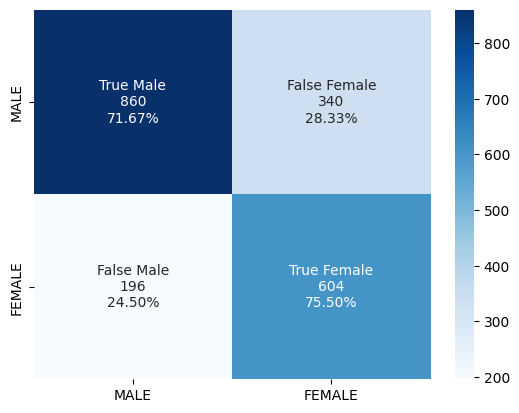

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id078.session02_split_name_sub-078_ses-02_desc-o_T2w/_run_None/sub-078_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id073.session02_split_name_sub-073_ses-02_desc-o_T2w/_run_None/sub-073_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id099.session02_split_name_sub-099_ses-02_desc-o_T2w/_run_None/sub-099_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id095.session02_split_name_sub-095_ses-02_desc-o_T2w/_run_None/sub-095_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_27_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_28_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

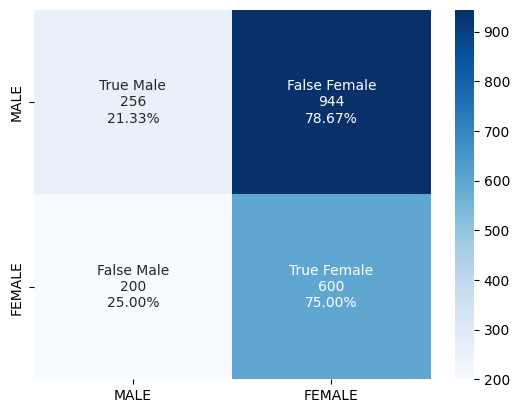

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id066.session02_split_name_sub-066_ses-02_desc-o_T2w/_run_None/sub-066_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id099.session02_split_name_sub-099_ses-02_desc-o_T2w/_run_None/sub-099_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id094.session02_split_name_sub-094_ses-02_desc-o_T2w/_run_None/sub-094_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_31_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_32_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

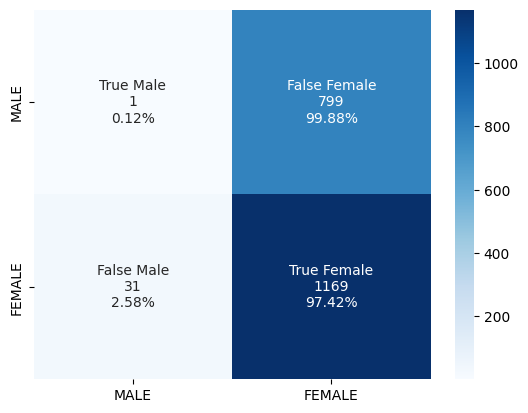

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id078.session02_split_name_sub-078_ses-02_desc-o_T2w/_run_None/sub-078_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id096.session02_split_name_sub-096_ses-02_desc-o_T2w/_run_None/sub-096_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id093.session02_split_name_sub-093_ses-02_desc-o_T2w/_run_None/sub-093_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_35_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_36_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

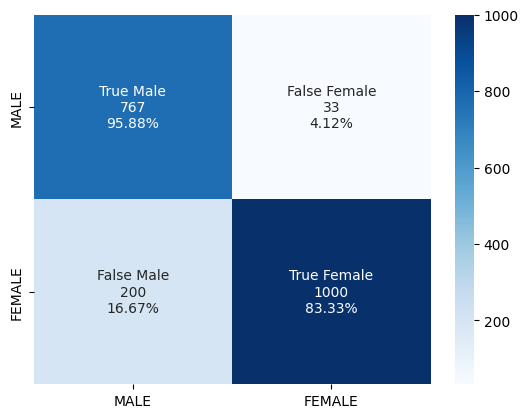

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id079.session02_split_name_sub-079_ses-02_desc-o_T2w/_run_None/sub-079_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id099.session02_split_name_sub-099_ses-02_desc-o_T2w/_run_None/sub-099_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id094.session02_split_name_sub-094_ses-02_desc-o_T2w/_run_None/sub-094_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_39_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_40_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

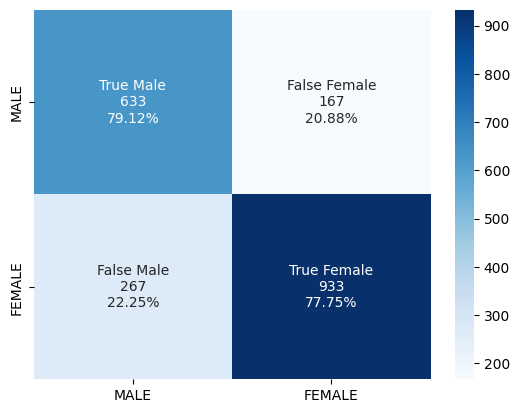

histories and scores from VGG 16 M2D


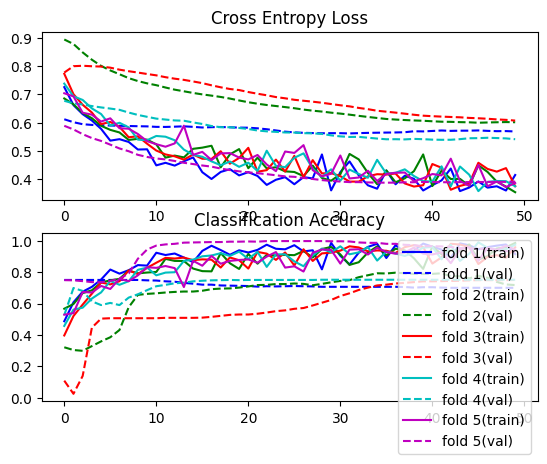

Accuracy: mean=68.230 std=15.952, n=5


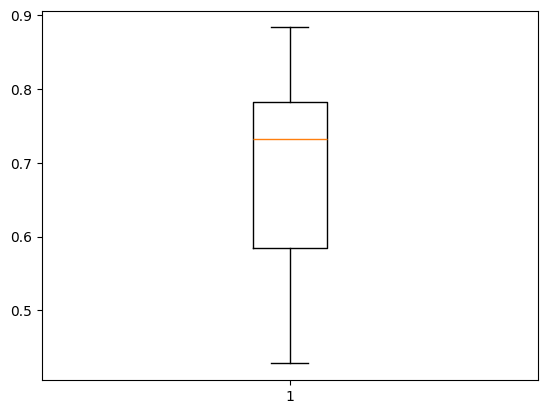

In [17]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores, histories = list(), list()

for train_ix, test_ix in kfold.split(subjects, labels):
    sub_train = subjects[list(train_ix)]
    sub_train, sub_val, y_train, y_val  = train_test_split(sub_train, labels[list(train_ix)], test_size=0.1, random_state=42)
    sub_test = subjects[list(test_ix)]
    
    CPHclassTrain = FILES_and_LABELS(sub_train, sessions, MRI_type, functional_type)
    CPHclassTest = FILES_and_LABELS(sub_test, sessions, MRI_type, functional_type)
    CPHclassval = FILES_and_LABELS(sub_val, sessions, MRI_type, functional_type)
        
    X_train = CPHclassTrain.get_mask_and_bold()
    X_test = CPHclassTest.get_mask_and_bold()
    X_val = CPHclassval.get_mask_and_bold()

    print("sub train:")
    print(np.array(X_train)[:,0])
    print("sub test:")
    print(np.array(X_test)[:,0])
    print("sub val:")
    print(np.array(X_val)[:,0])

    print("# sesiones Train",len(X_train))
    print("# sesiones Test",len(X_test))
    print("# sesiones Val",len(X_val))
    
    traingen = CustomDataGen(X_train, batch_size=6, format = "just_brain_M2D", vols = 200, num_class = 2, classes = "sex")
    #Es necesario que la division entre X_test y batch_size tenga un modulo igual a 0. De otra manera el ultimo batch no lo utiliza al utilizar .predict
    testgen  = CustomDataGen(X_test, batch_size=1, format = "just_brain_M2D", vols=200, num_class = 2, classes = "sex")
    valgen  = CustomDataGen(X_val, batch_size=len(X_val), format = "just_brain_M2D",vols=200, num_class = 2, classes = "sex")
    
    #getting model 3D CNN
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)
    print("Starting VGG 16 M2D-----------------------------------------------------")
    CNN = VGG16_cnn2d_method()
    CNN.compile(loss=tf.nn.softmax_cross_entropy_with_logits, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    metrics=["Accuracy"])
    
    start_time = datetime.now()
    
    print("Training")
    history = CNN.fit(traingen, epochs=50, validation_data = valgen, shuffle=True)

    end_time = datetime.now()
    print('Duration (CNN): {}'.format(end_time - start_time))

    y_test=[]
    for i in range(int(len(X_test)/1)):
        x,y = testgen[i]
        y_test.extend(y)
    y_test = np.argmax(y_test, axis=1)
    
    print("predicts CNN")
    preds = tf.cast(tf.argmax(CNN.predict(testgen), axis=1), tf.int32)
    
    print("evaluating CNN")
    _,acc = CNN.evaluate(testgen, verbose=1)
    
    scores.append(acc)
    histories.append(history)
    
    print("CM CNN")
    confusionmatrix(y_test, preds)
        
print("histories and scores from VGG 16 M2D") 
summarize_diagnostics(histories)
summarize_performance(scores)

## Whit z scoring

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id079.session02_split_name_sub-079_ses-02_desc-o_T2w/_run_None/sub-079_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id060.session02_split_name_sub-060_ses-02_desc-o_T2w/_run_None/sub-060_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id100.session02_split_name_sub-100_ses-02_desc-o_T2w/_run_None/sub-100_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id096.session02_split_name_sub-096_ses-02_desc-o_T2w/_run_None/sub-096_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                             

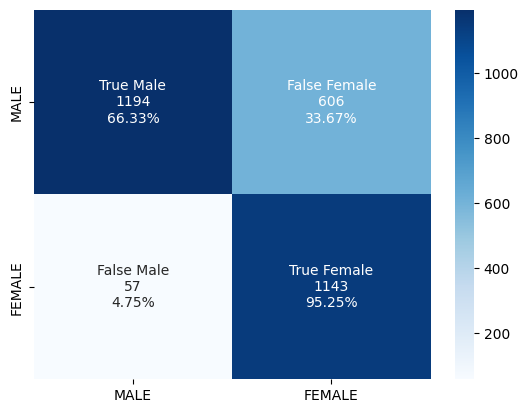

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id078.session02_split_name_sub-078_ses-02_desc-o_T2w/_run_None/sub-078_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id073.session02_split_name_sub-073_ses-02_desc-o_T2w/_run_None/sub-073_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id099.session02_split_name_sub-099_ses-02_desc-o_T2w/_run_None/sub-099_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id095.session02_split_name_sub-095_ses-02_desc-o_T2w/_run_None/sub-095_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_7_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_8_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                           

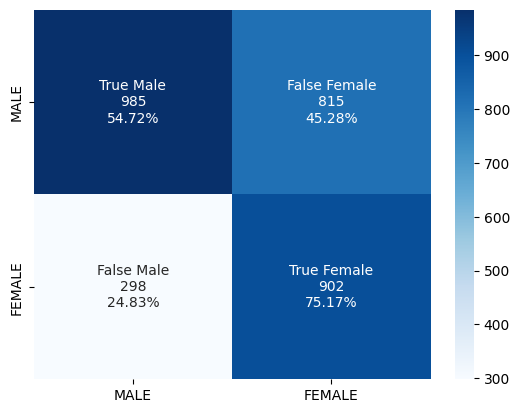

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id066.session02_split_name_sub-066_ses-02_desc-o_T2w/_run_None/sub-066_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id099.session02_split_name_sub-099_ses-02_desc-o_T2w/_run_None/sub-099_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id094.session02_split_name_sub-094_ses-02_desc-o_T2w/_run_None/sub-094_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_11_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_12_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

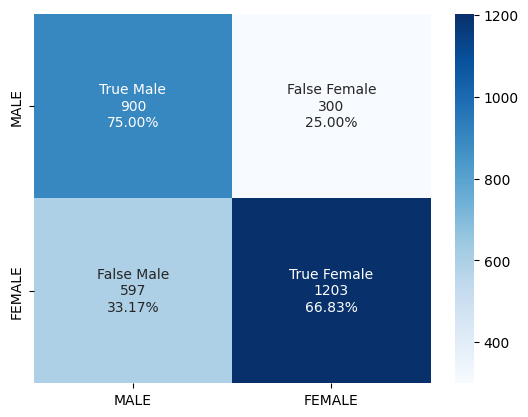

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id078.session02_split_name_sub-078_ses-02_desc-o_T2w/_run_None/sub-078_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id096.session02_split_name_sub-096_ses-02_desc-o_T2w/_run_None/sub-096_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id093.session02_split_name_sub-093_ses-02_desc-o_T2w/_run_None/sub-093_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_15_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_16_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

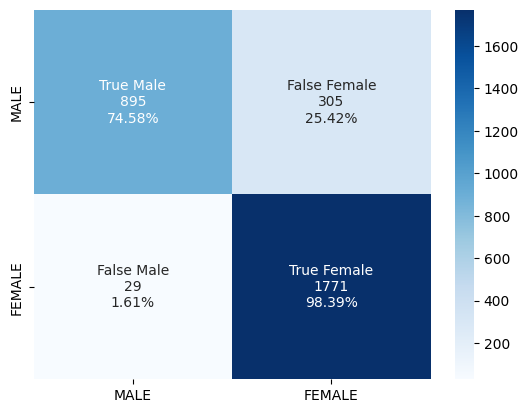

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id079.session02_split_name_sub-079_ses-02_desc-o_T2w/_run_None/sub-079_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id099.session02_split_name_sub-099_ses-02_desc-o_T2w/_run_None/sub-099_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id094.session02_split_name_sub-094_ses-02_desc-o_T2w/_run_None/sub-094_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_19_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_20_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

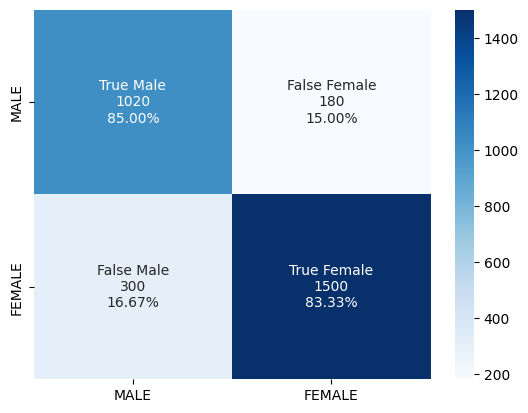

histories and scores from VGG 16 M2D


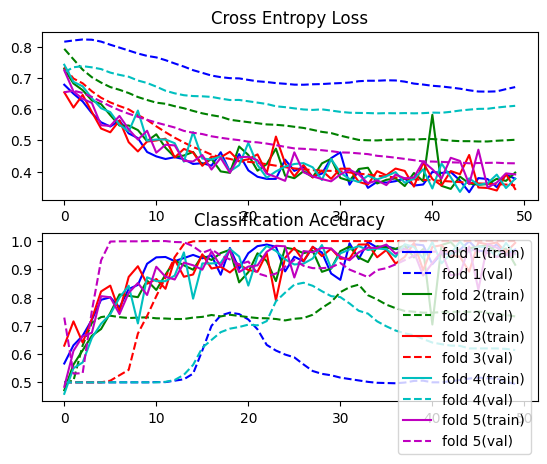

Accuracy: mean=76.753 std=9.346, n=5


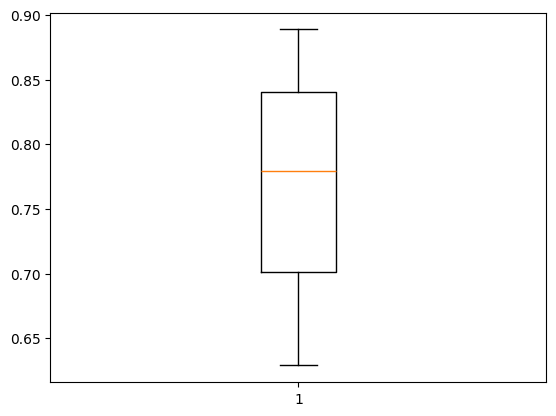

In [7]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores, histories = list(), list()

for train_ix, test_ix in kfold.split(subjects, labels):
    sub_train = subjects[list(train_ix)]
    sub_train, sub_val, y_train, y_val  = train_test_split(sub_train, labels[list(train_ix)], test_size=0.1, random_state=42)
    sub_test = subjects[list(test_ix)]
    
    CPHclassTrain = FILES_and_LABELS(sub_train, sessions, MRI_type, functional_type)
    CPHclassTest = FILES_and_LABELS(sub_test, sessions, MRI_type, functional_type)
    CPHclassval = FILES_and_LABELS(sub_val, sessions, MRI_type, functional_type)
        
    X_train = CPHclassTrain.get_mask_and_bold()
    X_test = CPHclassTest.get_mask_and_bold()
    X_val = CPHclassval.get_mask_and_bold()

    print("sub train:")
    print(np.array(X_train)[:,0])
    print("sub test:")
    print(np.array(X_test)[:,0])
    print("sub val:")
    print(np.array(X_val)[:,0])

    print("# sesiones Train",len(X_train))
    print("# sesiones Test",len(X_test))
    print("# sesiones Val",len(X_val))
    
    traingen = CustomDataGen(X_train, batch_size=6, format = "just_brain_M2D", vols = 300, num_class = 2, classes = "sex")
    #Es necesario que la division entre X_test y batch_size tenga un modulo igual a 0. De otra manera el ultimo batch no lo utiliza al utilizar .predict
    testgen  = CustomDataGen(X_test, batch_size=1, format = "just_brain_M2D", vols=300, num_class = 2, classes = "sex")
    valgen  = CustomDataGen(X_val, batch_size=len(X_val), format = "just_brain_M2D",vols=300, num_class = 2, classes = "sex")
    
    #getting model 3D CNN
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)
    print("Starting VGG 16 M2D-----------------------------------------------------")
    CNN = VGG16_cnn2d_method()
    CNN.compile(loss=tf.nn.softmax_cross_entropy_with_logits, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    metrics=["Accuracy"])
    
    start_time = datetime.now()
    
    print("Training")
    history = CNN.fit(traingen, epochs=50, validation_data = valgen, shuffle=True)

    end_time = datetime.now()
    print('Duration (CNN): {}'.format(end_time - start_time))

    y_test=[]
    for i in range(int(len(X_test)/1)):
        x,y = testgen[i]
        y_test.extend(y)
    y_test = np.argmax(y_test, axis=1)
    
    print("predicts CNN")
    preds = tf.cast(tf.argmax(CNN.predict(testgen), axis=1), tf.int32)
    
    print("evaluating CNN")
    _,acc = CNN.evaluate(testgen, verbose=1)
    
    scores.append(acc)
    histories.append(history)
    
    print("CM CNN")
    confusionmatrix(y_test, preds)
        
print("histories and scores from VGG 16 M2D") 
summarize_diagnostics(histories)
summarize_performance(scores)

## Z scoring and hist equialization. More volumes. Fine tuning. 4-fold cross validation (for balanced datasets)

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id060.session02_split_name_sub-060_ses-02_desc-o_T2w/_run_None/sub-060_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id073.session02_split_name_sub-073_ses-02_desc-o_T2w/_run_None/sub-073_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id093.session02_split_name_sub-093_ses-02_desc-o_T2w/_run_None/sub-093_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                             

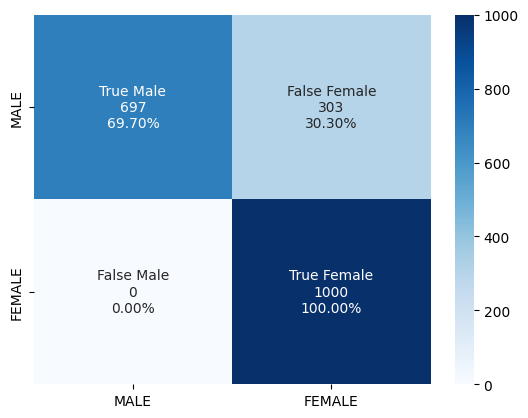

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id057.session02_split_name_sub-057_ses-02_desc-o_T2w/_run_None/sub-057_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id073.session02_split_name_sub-073_ses-02_desc-o_T2w/_run_None/sub-073_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id074.session02_split_name_sub-074_ses-02_desc-o_T2w/_run_None/sub-074_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id093.session02_split_name_sub-093_ses-02_desc-o_T2w/_run_None/sub-093_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_7_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_8_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                           

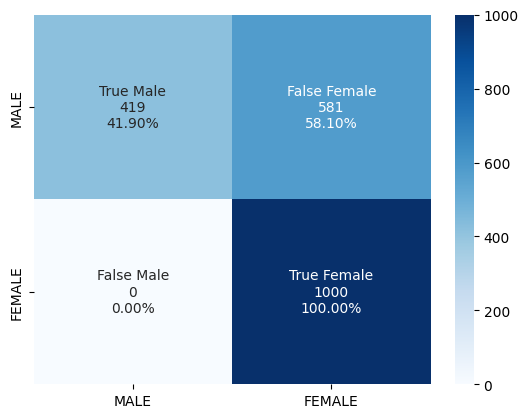

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id057.session02_split_name_sub-057_ses-02_desc-o_T2w/_run_None/sub-057_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id060.session02_split_name_sub-060_ses-02_desc-o_T2w/_run_None/sub-060_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id073.session02_split_name_sub-073_ses-02_desc-o_T2w/_run_None/sub-073_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_11_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_12_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

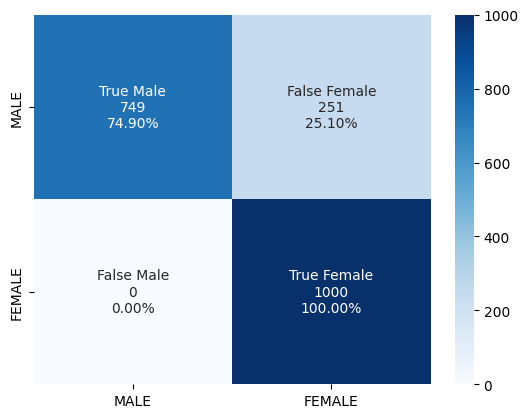

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id057.session02_split_name_sub-057_ses-02_desc-o_T2w/_run_None/sub-057_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id060.session02_split_name_sub-060_ses-02_desc-o_T2w/_run_None/sub-060_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id074.session02_split_name_sub-074_ses-02_desc-o_T2w/_run_None/sub-074_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_15_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_16_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

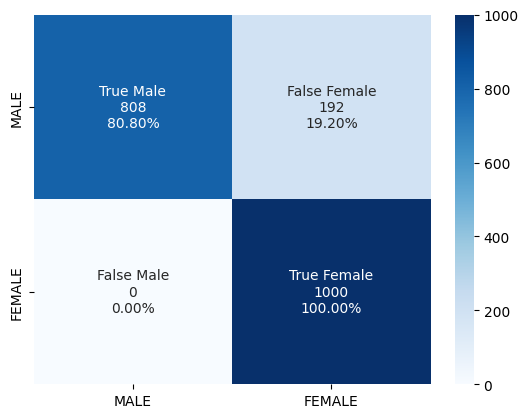

histories and scores from VGG 16 M2D


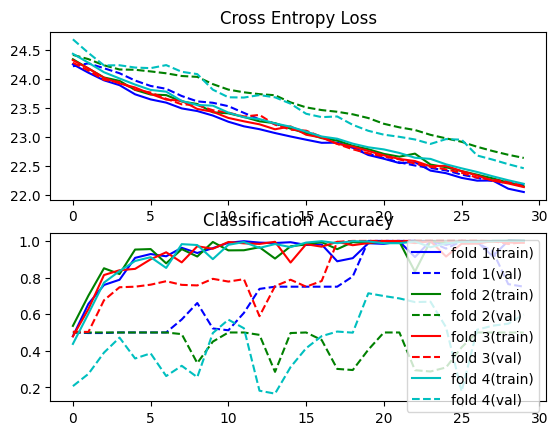

Accuracy: mean=83.412 std=7.458, n=4


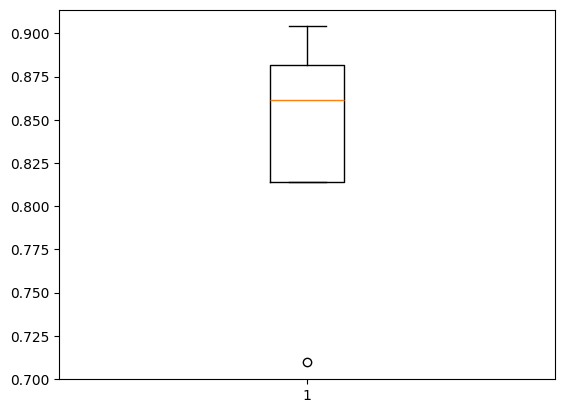

In [7]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores, histories = list(), list()

for train_ix, test_ix in kfold.split(subjects, labels):
    sub_train = subjects[list(train_ix)]
    sub_test = subjects[list(test_ix)]
    sub_test, sub_val, y_test, y_val  = train_test_split(sub_test, labels[list(test_ix)], test_size=0.2, random_state=42, stratify=labels[list(test_ix)])
    
    
    CPHclassTrain = FILES_and_LABELS(sub_train, sessions, MRI_type, functional_type)
    CPHclassTest = FILES_and_LABELS(sub_test, sessions, MRI_type, functional_type)
    CPHclassval = FILES_and_LABELS(sub_val, sessions, MRI_type, functional_type)
        
    X_train = CPHclassTrain.get_mask_and_bold()
    X_test = CPHclassTest.get_mask_and_bold()
    X_val = CPHclassval.get_mask_and_bold()

    print("sub train:")
    print(np.array(X_train)[:,0])
    m = []
    f = []
    for i in X_train:
        for j in male:
            if str(j) in i[0]:
                m.append(i)
        for j in female:
            if str(j) in i[0]:
                f.append(i)
    print("females: ", len(f))
    print("males: ", len(m))
    
    print("sub test:")
    print(np.array(X_test)[:,0])
    print("sub val:")
    print(np.array(X_val)[:,0])

    print("# sesiones Train",len(X_train))
    print("# sesiones Test",len(X_test))
    print("# sesiones Val",len(X_val))
    
    traingen = CustomDataGen(X_train, batch_size=6, format = "just_brain_M2D", vols = 250, num_class = 2, classes = "sex")
    #Es necesario que la division entre X_test y batch_size tenga un modulo igual a 0. De otra manera el ultimo batch no lo utiliza al utilizar .predict
    testgen  = CustomDataGen(X_test, batch_size=1, format = "just_brain_M2D", vols=250, num_class = 2, classes = "sex")
    valgen  = CustomDataGen(X_val, batch_size=len(X_val), format = "just_brain_M2D",vols=250, num_class = 2, classes = "sex")
    
    #getting model 3D CNN
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)
    print("Starting VGG 16 M2D-----------------------------------------------------")
    CNN = VGG16_cnn2d_method()
    #CNN.compile(loss=tf.nn.softmax_cross_entropy_with_logits, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    #metrics=["Accuracy"])
    
    start_time = datetime.now()
    
    print("Training")
    #history = CNN.fit(traingen, epochs=50, validation_data = valgen, shuffle=True)

    #Fine tuning
    # Unfreeze the base model
    CNN.trainable = True
    
    print("starting fine tuning")
    CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = .00001),  # Very low learning rate
                loss=tf.nn.softmax_cross_entropy_with_logits,
                metrics=["Accuracy"])
    history = CNN.fit(traingen, epochs=30, validation_data=valgen, shuffle=True)

    end_time = datetime.now()
    print('Duration (CNN): {}'.format(end_time - start_time))

    y_test=[]
    for i in range(int(len(X_test)/1)):
        x,y = testgen[i]
        y_test.extend(y)
    y_test = np.argmax(y_test, axis=1)
    
    print("predicts CNN")
    preds = tf.cast(tf.argmax(CNN.predict(testgen), axis=1), tf.int32)
    
    print("evaluating CNN")
    _,acc = CNN.evaluate(testgen, verbose=1)
    
    scores.append(acc)
    histories.append(history)
    
    print("CM CNN")
    confusionmatrix(y_test, preds)
        
print("histories and scores from VGG 16 M2D") 
summarize_diagnostics(histories)
summarize_performance(scores)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("VGG 16 m2d just brain-hist_eq_centered_vols_MvsF_{#fold}", 
                    monitor="val_Accuracy", mode="max", 
                    save_best_only=True, verbose=1)



## modificando el datagenerator para recibir subbatches menores al los volumenes usados por sesion

In [ ]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores, histories = list(), list()

for train_ix, test_ix in kfold.split(subjects, labels):
    sub_train = subjects[list(train_ix)]
    sub_test = subjects[list(test_ix)]
    sub_test, sub_val, y_test, y_val  = train_test_split(sub_test, labels[list(test_ix)], test_size=0.2, random_state=42, stratify=labels[list(test_ix)])
    
    
    CPHclassTrain = FILES_and_LABELS(sub_train, sessions, MRI_type, functional_type)
    CPHclassTest = FILES_and_LABELS(sub_test, sessions, MRI_type, functional_type)
    CPHclassval = FILES_and_LABELS(sub_val, sessions, MRI_type, functional_type)
        
    X_train = CPHclassTrain.get_mask_and_bold()
    X_test = CPHclassTest.get_mask_and_bold()
    X_val = CPHclassval.get_mask_and_bold()

    print("sub train:")
    print(np.array(X_train)[:,0])
    m = []
    f = []
    for i in X_train:
        for j in male:
            if str(j) in i[0]:
                m.append(i)
        for j in female:
            if str(j) in i[0]:
                f.append(i)
    print("females: ", len(f))
    print("males: ", len(m))
    
    print("sub test:")
    print(np.array(X_test)[:,0])
    print("sub val:")
    print(np.array(X_val)[:,0])

    print("# sesiones Train",len(X_train))
    print("# sesiones Test",len(X_test))
    print("# sesiones Val",len(X_val))
    
    traingen = CustomDataGen(X_train, batch_size=2,subbatch_size=116, format = "just_brain_M2D", vols = 580, num_class = 2, classes = "sex")
    #Es necesario que la division entre X_test y batch_size tenga un modulo igual a 0. De otra manera el ultimo batch no lo utiliza al utilizar .predict
    testgen  = CustomDataGen(X_test, batch_size=1,subbatch_size=580, format = "just_brain_M2D", vols=580, num_class = 2, classes = "sex")
    valgen  = CustomDataGen(X_val, batch_size=len(X_val),subbatch_size=116, format = "just_brain_M2D",vols=580, num_class = 2, classes = "sex")

    #organizamos las sesiones para que quede intercaladas por clases.
    print("Intercalando sesiones por clase")
    traingen.on_epoch_end()
    
    #getting model 3D CNN
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)
    print("Starting VGG 16 M2D-----------------------------------------------------")
    CNN = VGG16_cnn2d_method()
    #CNN.compile(loss=tf.nn.softmax_cross_entropy_with_logits, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    #metrics=["Accuracy"])
    
    start_time = datetime.now()
    
    print("Training")
    #history = CNN.fit(traingen, epochs=50, validation_data = valgen, shuffle=True)

    #Fine tuning
    # Unfreeze the base model
    CNN.trainable = True
    
    print("starting fine tuning")
    CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = .00001),  # Very low learning rate
                loss=tf.nn.softmax_cross_entropy_with_logits,
                metrics=["Accuracy"])
    history = CNN.fit(traingen, epochs=30, validation_data=valgen, shuffle=True)

    end_time = datetime.now()
    print('Duration (CNN): {}'.format(end_time - start_time))

    y_test=[]
    for i in range(int(len(X_test)/1)):
        x,y = testgen[i]
        y_test.extend(y)
    y_test = np.argmax(y_test, axis=1)
    
    print("predicts CNN")
    preds = tf.cast(tf.argmax(CNN.predict(testgen), axis=1), tf.int32)
    
    print("evaluating CNN")
    _,acc = CNN.evaluate(testgen, verbose=1)
    
    scores.append(acc)
    histories.append(history)
    
    print("CM CNN")
    confusionmatrix(y_test, preds)
        
print("histories and scores from VGG 16 M2D") 
summarize_diagnostics(histories)
summarize_performance(scores)

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id060.session02_split_name_sub-060_ses-02_desc-o_T2w/_run_None/sub-060_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id073.session02_split_name_sub-073_ses-02_desc-o_T2w/_run_None/sub-073_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id093.session02_split_name_sub-093_ses-02_desc-o_T2w/_run_None/sub-093_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                             

# Just brain Female (Naive) vs Female (CPH)


In [6]:
femaleCPHw1w7 = [49,50,51,52,65,66,77,78,79,80,81,82]
femaleNaive3sess = [19,20,67,68]
femaleCPHbaseline = [49,50,51,52,65,66,77,78,79,80,81,82]

y_CPH = np.ones(len(femaleCPHw1w7))
y_NAIVE = np.zeros(len(femaleNaive3sess))
y_CPH_bl = [2]*np.ones(len(femaleCPHbaseline))

subjects = np.array(femaleCPHw1w7+femaleNaive3sess+femaleCPHbaseline)
labels = np.array(list(y_CPH)+list(y_NAIVE)+list(y_CPH_bl))

MRI_type = "func"
functional_type = "rest"

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id050.session02_split_name_sub-050_ses-02_desc-o_T2w/_run_None/sub-050_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id051.session02_split_name_sub-051_ses-02_desc-o_T2w/_run_None/sub-051_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id052.session02_split_name_sub-052_ses-02_desc-o_T2w/_run_None/sub-052_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id066.session02_split_name_sub-066_ses-02_desc-o_T2w/_run_None/sub-066_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                             

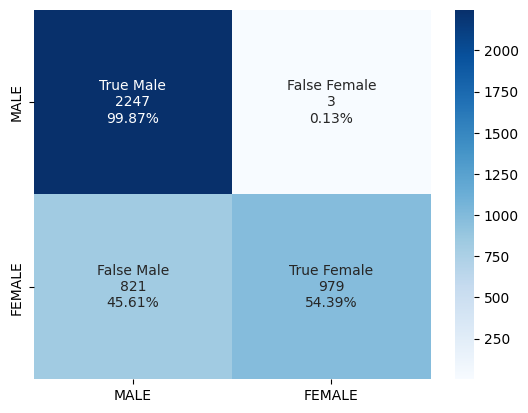

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id049.session02_split_name_sub-049_ses-02_desc-o_T2w/_run_None/sub-049_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id052.session02_split_name_sub-052_ses-02_desc-o_T2w/_run_None/sub-052_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id065.session02_split_name_sub-065_ses-02_desc-o_T2w/_run_None/sub-065_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id066.session02_split_name_sub-066_ses-02_desc-o_T2w/_run_None/sub-066_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_7_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_8_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                           

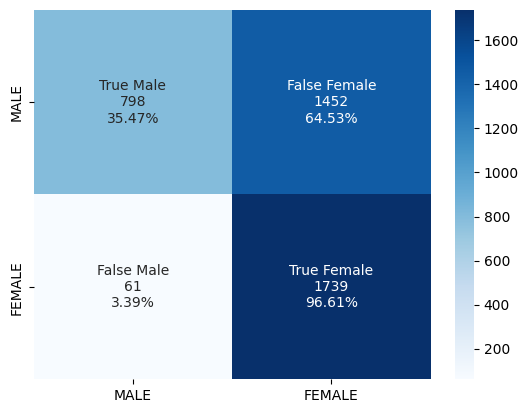

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id049.session02_split_name_sub-049_ses-02_desc-o_T2w/_run_None/sub-049_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id050.session02_split_name_sub-050_ses-02_desc-o_T2w/_run_None/sub-050_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id051.session02_split_name_sub-051_ses-02_desc-o_T2w/_run_None/sub-051_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id052.session02_split_name_sub-052_ses-02_desc-o_T2w/_run_None/sub-052_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_11_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_12_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

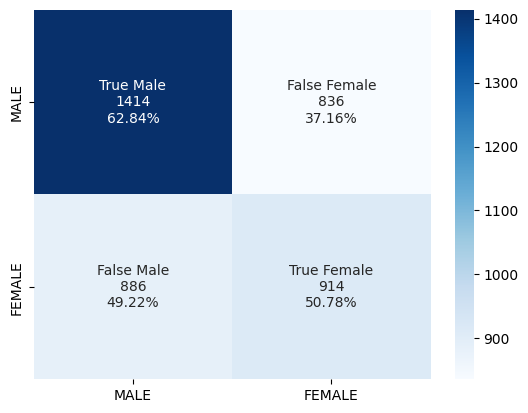

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id049.session02_split_name_sub-049_ses-02_desc-o_T2w/_run_None/sub-049_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id050.session02_split_name_sub-050_ses-02_desc-o_T2w/_run_None/sub-050_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id051.session02_split_name_sub-051_ses-02_desc-o_T2w/_run_None/sub-051_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id065.session02_split_name_sub-065_ses-02_desc-o_T2w/_run_None/sub-065_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_15_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_16_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

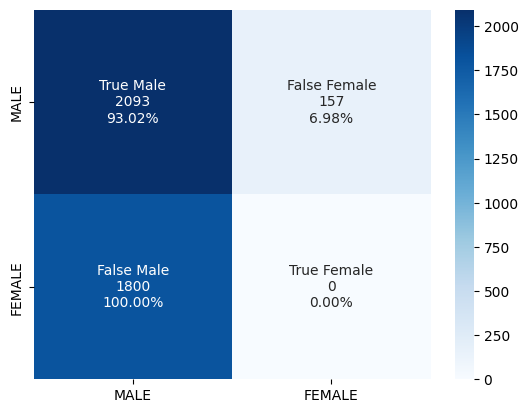

histories and scores from VGG 16 M2D


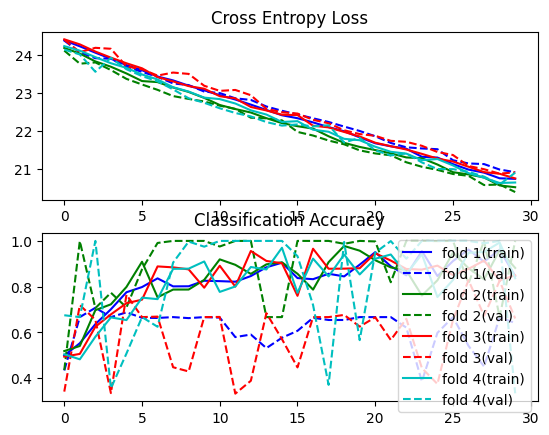

Accuracy: mean=62.864 std=10.441, n=4


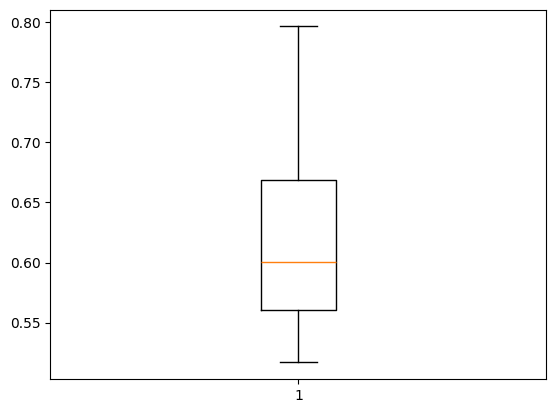

In [7]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores, histories = list(), list()
scores_cam, histories_cam = list(), list()


for train_ix, test_ix in kfold.split(subjects, labels):
    sub_train = subjects[list(train_ix)]
    y_train = labels[list(train_ix)]
  
    ext_x = np.append(subjects[list(test_ix)],np.array([1000]))
    ext_y = np.append(labels[list(test_ix)],np.array([0]))
    
    sub_test, sub_val, y_test, y_val  = train_test_split(ext_x, 
                                                         ext_y,
                                                         test_size=0.3, random_state=42,
                                                         stratify=ext_y)
    #Sujetos CPH con dos sesiones
    femaleCPHw1w7_train = []
    for i in range(len(sub_train)):
        if sub_train[i] in femaleCPHw1w7 and y_train[i] == 1:
            femaleCPHw1w7_train.append(sub_train[i])
           
    femaleCPHw1w7_test = []
    for i in range(len(sub_test)):
        if sub_test[i] in femaleCPHw1w7 and y_test[i] == 1:
            femaleCPHw1w7_test.append(sub_test[i])
     
    femaleCPHw1w7_val = []
    for i in range(len(sub_val)):
        if sub_val[i] in femaleCPHw1w7 and y_val[i] == 1:
            femaleCPHw1w7_val.append(sub_val[i])
    
    #Sujetos NAIVE tres sesiones
    femaleNaive3sess_train = []
    for i in sub_train:
        if i in femaleNaive3sess:
            femaleNaive3sess_train.append(i)
            
    femaleNaive3sess_test = []
    for i in sub_test:
        if i in femaleNaive3sess:
            femaleNaive3sess_test.append(i)
    
    femaleNaive3sess_val = []
    for i in sub_val:
        if i in femaleNaive3sess:
            femaleNaive3sess_val.append(i)
    
    #Sujetos CPH baseline
    femaleCPHBl_train = []
    for i in range(len(sub_train)):
        if sub_train[i] in femaleCPHbaseline and y_train[i] == 2:
            femaleCPHBl_train.append(sub_train[i])
            
    femaleCPHBl_test = []
    for i in range(len(sub_test)):
        if sub_test[i] in femaleCPHbaseline and y_test[i] == 2:
            femaleCPHBl_test.append(sub_test[i])
    
    femaleCPHBl_val = []
    for i in range(len(sub_val)):
        if sub_val[i] in femaleCPHbaseline and y_val[i] == 2:
            femaleCPHBl_val.append(sub_val[i])
    
    #CPH W1 and W7 (train, test, val)
    CPHTrain = FILES_and_LABELS(femaleCPHw1w7_train, [2,3], MRI_type, functional_type)
    CPHTest = FILES_and_LABELS(femaleCPHw1w7_test, [2,3], MRI_type, functional_type)
    CPHVal = FILES_and_LABELS(femaleCPHw1w7_val, [2,3], MRI_type, functional_type)
        
    CPH_train_path = CPHTrain.get_mask_and_bold()
    CPH_test_path = CPHTest.get_mask_and_bold()
    CPH_val_path = CPHVal.get_mask_and_bold()
    
    #NAIVE three sessions
    NAIVE3Train = FILES_and_LABELS(femaleNaive3sess_train, [1,2,3], MRI_type, functional_type)
    NAIVE3Test = FILES_and_LABELS(femaleNaive3sess_test, [1,2,3], MRI_type, functional_type)
    NAIVE3Val = FILES_and_LABELS(femaleNaive3sess_val, [1,2,3], MRI_type, functional_type)
        
    NAIVE3_train_path = NAIVE3Train.get_mask_and_bold()
    NAIVE3_test_path = NAIVE3Test.get_mask_and_bold()
    NAIVE3_val_path = NAIVE3Val.get_mask_and_bold()
    
    #CPH Session 1 Baseline
    BL_CPHTrain = FILES_and_LABELS(femaleCPHBl_train, [1], MRI_type, functional_type)
    BL_CPHTest = FILES_and_LABELS(femaleCPHBl_test, [1], MRI_type, functional_type)
    BL_CPHVal = FILES_and_LABELS(femaleCPHBl_val, [1], MRI_type, functional_type)
        
    BL_CPH_train_path = BL_CPHTrain.get_mask_and_bold()
    BL_CPH_test_path = BL_CPHTest.get_mask_and_bold()
    BL_CPH_val_path = BL_CPHVal.get_mask_and_bold()
        
    X_train = CPH_train_path+NAIVE3_train_path+BL_CPH_train_path
    X_test =  CPH_test_path+NAIVE3_test_path+BL_CPH_test_path
    X_val = CPH_val_path+NAIVE3_val_path+BL_CPH_val_path

    print("sub train:")
    print(np.array(X_train)[:,0])
    print("sub test:")
    print(np.array(X_test)[:,0])
    print("sub val:")
    print(np.array(X_val)[:,0])
    
    print("# sesiones CPH (W1 and W7) Train",len(CPH_train_path))
    print("# sesiones NAIVE (3 sessions) Train",len(NAIVE3_train_path))
    print("# sesiones CPH baseline Train",len(BL_CPH_train_path))

    print("# sesiones Train",len(X_train))
    print("# sesiones Test",len(X_test))
    print("# sesiones Val",len(X_val))    
    traingen = CustomDataGen(X_train, batch_size=3, format = "just_brain_M2D", vols = 450, num_class = 2, classes = "CPHvsNAIVEfemale")
    #Es necesario que la division entre X_test y batch_size tenga un modulo igual a 0. De otra manera el ultimo batch no lo utiliza al utilizar .predict
    testgen  = CustomDataGen(X_test, batch_size=1, format = "just_brain_M2D", vols=450, num_class = 2, classes = "CPHvsNAIVEfemale")
    valgen  = CustomDataGen(X_val, batch_size=len(X_val), format = "just_brain_M2D",vols=450, num_class = 2, classes = "CPHvsNAIVEfemale")
    
    #getting model 3D CNN
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)
    print("Starting VGG 16 M2D-----------------------------------------------------")
    CNN = VGG16_cnn2d_method()
    #CNN.compile(loss=tf.nn.softmax_cross_entropy_with_logits, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    #                metrics=["Accuracy"])
    
    start_time = datetime.now()
    
    print("Training")
    #history = CNN.fit(traingen, epochs=50, validation_data = valgen, shuffle=True)

    #Fine tuning
    # Unfreeze the base model
    CNN.trainable = True

    print("starting fine tuning")
    CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = .00001),  # Very low learning rate
                loss=tf.nn.softmax_cross_entropy_with_logits,
                metrics=["Accuracy"])
    history = CNN.fit(traingen, epochs=30, validation_data=valgen, shuffle=True)

    end_time = datetime.now()
    print('Duration (CNN): {}'.format(end_time - start_time))

    y_test=[]
    for i in range(int(len(X_test)/1)):
        x,y = testgen[i]
        y_test.extend(y)
    y_test = np.argmax(y_test, axis=1)
    
    print("predicts CNN")
    preds = tf.cast(tf.argmax(CNN.predict(testgen), axis=1), tf.int32)
    
    print("evaluating CNN")
    _,acc = CNN.evaluate(testgen, verbose=1)
    
    scores.append(acc)
    histories.append(history)
    
    print("CM CNN")
    confusionmatrix(y_test, preds)

print("histories and scores from VGG 16 M2D") 
summarize_diagnostics(histories)
summarize_performance(scores)

# Just brain Male (Naive) VS Male (CPH)

In [6]:
maleCPHw1w7 = [57,59,60,73,74,93,94,95,96,98,99,100]
maleCPHbaseline = [57,59,60,73,74,93,94,95,96,98,99,100]
maleNaive3sess = [24,28,75,76]


y_CPH = np.ones(len(maleCPHw1w7))
y_NAIVE = np.zeros(len(maleNaive3sess))
y_cph_bl = [2]*np.ones(len(maleCPHbaseline))

subjects = np.array(maleCPHw1w7+maleCPHbaseline+maleNaive3sess)
labels = np.array(list(y_CPH)+list(y_cph_bl)+list(y_NAIVE))

MRI_type = "func"
functional_type = "rest"

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id060.session02_split_name_sub-060_ses-02_desc-o_T2w/_run_None/sub-060_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id073.session02_split_name_sub-073_ses-02_desc-o_T2w/_run_None/sub-073_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id093.session02_split_name_sub-093_ses-02_desc-o_T2w/_run_None/sub-093_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                             

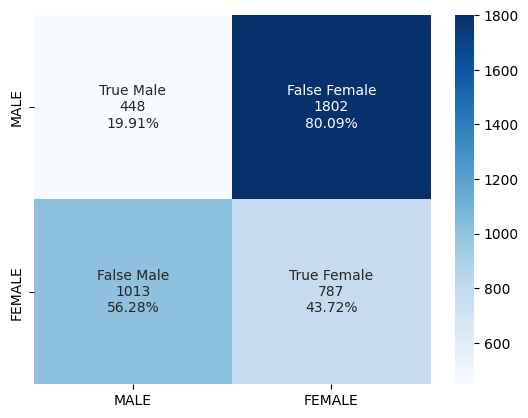

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id057.session02_split_name_sub-057_ses-02_desc-o_T2w/_run_None/sub-057_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id073.session02_split_name_sub-073_ses-02_desc-o_T2w/_run_None/sub-073_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id074.session02_split_name_sub-074_ses-02_desc-o_T2w/_run_None/sub-074_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id093.session02_split_name_sub-093_ses-02_desc-o_T2w/_run_None/sub-093_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_7_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_8_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                           

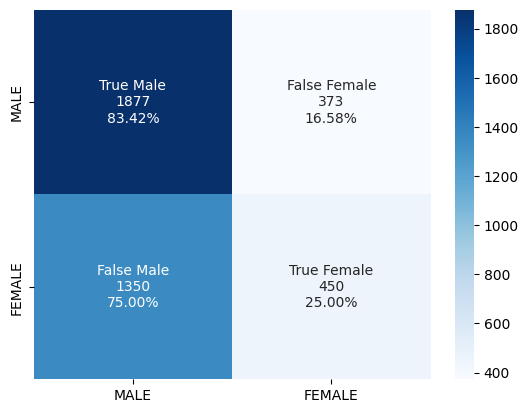

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id057.session02_split_name_sub-057_ses-02_desc-o_T2w/_run_None/sub-057_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id060.session02_split_name_sub-060_ses-02_desc-o_T2w/_run_None/sub-060_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id073.session02_split_name_sub-073_ses-02_desc-o_T2w/_run_None/sub-073_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_11_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_12_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

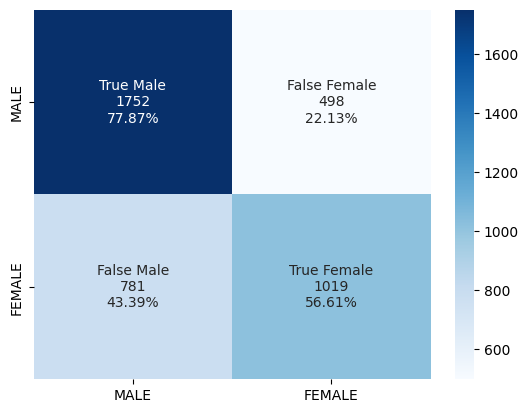

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id057.session02_split_name_sub-057_ses-02_desc-o_T2w/_run_None/sub-057_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id059.session02_split_name_sub-059_ses-02_desc-o_T2w/_run_None/sub-059_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id060.session02_split_name_sub-060_ses-02_desc-o_T2w/_run_None/sub-060_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-002_rest/bold_datasink/commonspace_bold/_scan_info_subject_id074.session02_split_name_sub-074_ses-02_desc-o_T2w/_run_None/sub-074_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_15_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_16_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

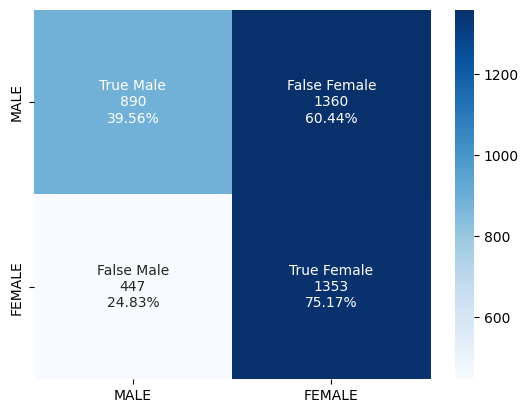

histories and scores from VGG 16 M2D


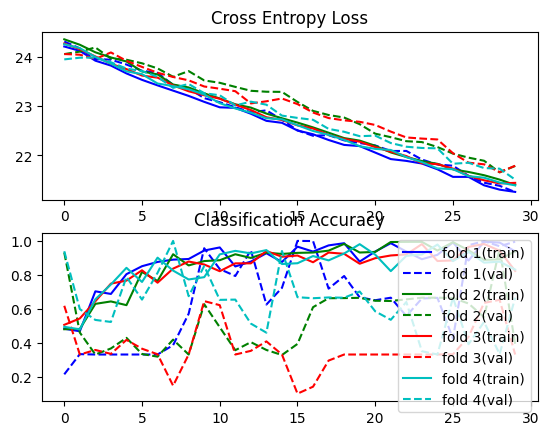

Accuracy: mean=52.938 std=13.873, n=4


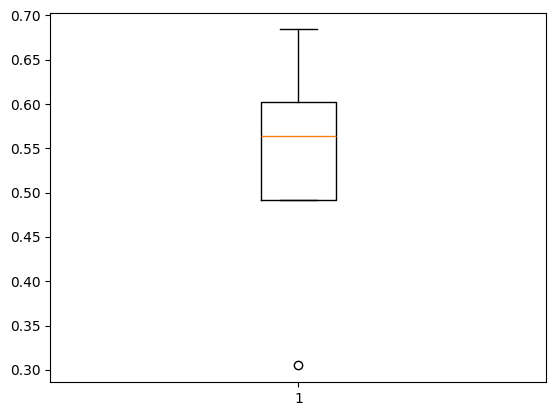

In [7]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores, histories = list(), list()
scores_cam, histories_cam = list(), list()

for train_ix, test_ix in kfold.split(subjects, labels):
    sub_train = subjects[list(train_ix)]
    y_train = labels[list(train_ix)]
    sub_test = subjects[list(test_ix)]

    ext_x = np.append(subjects[list(test_ix)],np.array([1000]))
    ext_y = np.append(labels[list(test_ix)],np.array([0]))
    
    sub_test, sub_val, y_test, y_val  = train_test_split(ext_x, 
                                                         ext_y,
                                                         test_size=0.3, random_state=42,
                                                         stratify=ext_y)
    #Sujetos CPH con dos sesiones
    maleCPHw1w7_train = []
    for i in range(len(sub_train)):
        if sub_train[i] in maleCPHw1w7 and y_train[i] == 1:
            maleCPHw1w7_train.append(sub_train[i])
            
    maleCPHw1w7_test = []
    for i in range(len(sub_test)):
        if sub_test[i] in maleCPHw1w7 and y_test[i] == 1:
            maleCPHw1w7_test.append(sub_test[i])
    
    maleCPHw1w7_val = []
    for i in range(len(sub_val)):
        if sub_val[i] in maleCPHw1w7 and y_val[i] == 1:
            maleCPHw1w7_val.append(sub_val[i])

    #Sujetos NAIVE tres sesiones
    maleNaive3sess_train = []
    for i in sub_train:
        if i in maleNaive3sess:
            maleNaive3sess_train.append(i)
            
    maleNaive3sess_test = []
    for i in sub_test:
        if i in maleNaive3sess:
            maleNaive3sess_test.append(i)
    
    maleNaive3sess_val = []
    for i in sub_val:
        if i in maleNaive3sess:
            maleNaive3sess_val.append(i)

    #Sujetos CPH baseline
    maleCPHBl_train = []
    for i in range(len(sub_train)):
        if sub_train[i] in maleCPHbaseline and y_train[i] == 2:
            maleCPHBl_train.append(sub_train[i])
            
    maleCPHBl_test = []
    for i in range(len(sub_test)):
        if sub_test[i] in maleCPHbaseline and y_test[i] == 2:
            maleCPHBl_test.append(sub_test[i])
    
    maleCPHBl_val = []
    for i in range(len(sub_val)):
        if sub_val[i] in maleCPHbaseline and y_val[i] == 2:
            maleCPHBl_val.append(sub_val[i])

    #CPH W1 and W7 (train, test, val)
    CPHTrain = FILES_and_LABELS(maleCPHw1w7_train, [2,3], MRI_type, functional_type)
    CPHTest = FILES_and_LABELS(maleCPHw1w7_test, [2,3], MRI_type, functional_type)
    CPHVal = FILES_and_LABELS(maleCPHw1w7_val, [2,3], MRI_type, functional_type)
        
    CPH_train_path = CPHTrain.get_mask_and_bold()
    CPH_test_path = CPHTest.get_mask_and_bold()
    CPH_val_path = CPHVal.get_mask_and_bold()
    
    #NAIVE three sessions
    NAIVE3Train = FILES_and_LABELS(maleNaive3sess_train, [1,2,3], MRI_type, functional_type)
    NAIVE3Test = FILES_and_LABELS(maleNaive3sess_test, [1,2,3], MRI_type, functional_type)
    NAIVE3Val = FILES_and_LABELS(maleNaive3sess_val, [1,2,3], MRI_type, functional_type)
        
    NAIVE3_train_path = NAIVE3Train.get_mask_and_bold()
    NAIVE3_test_path = NAIVE3Test.get_mask_and_bold()
    NAIVE3_val_path = NAIVE3Val.get_mask_and_bold()
    
    #CPH Session 1 Baseline
    BL_CPHTrain = FILES_and_LABELS(maleCPHBl_train, [1], MRI_type, functional_type)
    BL_CPHTest = FILES_and_LABELS(maleCPHBl_test, [1], MRI_type, functional_type)
    BL_CPHVal = FILES_and_LABELS(maleCPHBl_val, [1], MRI_type, functional_type)
        
    BL_CPH_train_path = BL_CPHTrain.get_mask_and_bold()
    BL_CPH_test_path = BL_CPHTest.get_mask_and_bold()
    BL_CPH_val_path = BL_CPHVal.get_mask_and_bold()
        
    X_train = CPH_train_path+NAIVE3_train_path+BL_CPH_train_path
    X_test =  CPH_test_path+NAIVE3_test_path+BL_CPH_test_path
    X_val = CPH_val_path+NAIVE3_val_path+BL_CPH_val_path

    print("sub train:")
    print(np.array(X_train)[:,0])
    print("sub test:")
    print(np.array(X_test)[:,0])
    print("sub val:")
    print(np.array(X_val)[:,0])

    print("# sesiones CPH (W1 and W7) Train",len(CPH_train_path))
    print("# sesiones NAIVE (3 sessions) Train",len(NAIVE3_train_path))
    print("# sesiones CPH baseline Train",len(BL_CPH_train_path))

    print("# sesiones Train",len(X_train))
    print("# sesiones Test",len(X_test))
    print("# sesiones Val",len(X_val))
    
    traingen = CustomDataGen(X_train, batch_size=4, format = "just_brain_M2D", vols = 450, num_class = 2, classes = "CPHvsNAIVEmale")
    #Es necesario que la division entre X_test y batch_size tenga un modulo igual a 0. De otra manera el ultimo batch no lo utiliza al utilizar .predict
    testgen  = CustomDataGen(X_test, batch_size=1, format = "just_brain_M2D", vols=450, num_class = 2, classes = "CPHvsNAIVEmale")
    valgen  = CustomDataGen(X_val, batch_size=len(X_val), format = "just_brain_M2D",vols=450, num_class = 2, classes = "CPHvsNAIVEmale")
    
    #getting model 3D CNN
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)
    print("Starting VGG 16 M2D-----------------------------------------------------")
    CNN = VGG16_cnn2d_method()
    #CNN.compile(loss=tf.nn.softmax_cross_entropy_with_logits, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    #                metrics=["Accuracy"])
    
    start_time = datetime.now()
    
    print("Training")
    #history = CNN.fit(traingen, epochs=50, validation_data = valgen, shuffle=True)

    #Fine tuning
    # Unfreeze the base model
    CNN.trainable = True

    print("starting fine tuning")
    CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = .00001),  # Very low learning rate
                loss=tf.nn.softmax_cross_entropy_with_logits,
                metrics=["Accuracy"])
    history = CNN.fit(traingen, epochs=30, validation_data=valgen, shuffle=True)

    end_time = datetime.now()
    print('Duration (CNN): {}'.format(end_time - start_time))

    y_test=[]
    for i in range(int(len(X_test)/1)):
        x,y = testgen[i]
        y_test.extend(y)
    y_test = np.argmax(y_test, axis=1)
    
    print("predicts CNN")
    preds = tf.cast(tf.argmax(CNN.predict(testgen), axis=1), tf.int32)
    
    print("evaluating CNN")
    _,acc = CNN.evaluate(testgen, verbose=1)
    
    scores.append(acc)
    histories.append(history)
    
    print("CM CNN")
    confusionmatrix(y_test, preds)
    
print("histories and scores from VGG 16 M2D") 
summarize_diagnostics(histories)
summarize_performance(scores)

# Female (CPH) vs Female (Naieve). 150 epochs.

In [6]:
femaleCPHw1w7 = [49,50,51,52,65,66,77,78,79,80,81,82]
femaleNaive3sess = [19,20,67,68]
femaleCPHbaseline = [49,50,51,52,65,66,77,78,79,80,81,82]

y_CPH = np.ones(len(femaleCPHw1w7))
y_NAIVE = np.zeros(len(femaleNaive3sess))
y_CPH_bl = [2]*np.ones(len(femaleCPHbaseline))

subjects = np.array(femaleCPHw1w7+femaleNaive3sess+femaleCPHbaseline)
labels = np.array(list(y_CPH)+list(y_NAIVE)+list(y_CPH_bl))

MRI_type = "func"
functional_type = "rest"

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id050.session02_split_name_sub-050_ses-02_desc-o_T2w/_run_None/sub-050_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id051.session02_split_name_sub-051_ses-02_desc-o_T2w/_run_None/sub-051_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id052.session02_split_name_sub-052_ses-02_desc-o_T2w/_run_None/sub-052_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id066.session02_split_name_sub-066_ses-02_desc-o_T2w/_run_None/sub-066_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                             

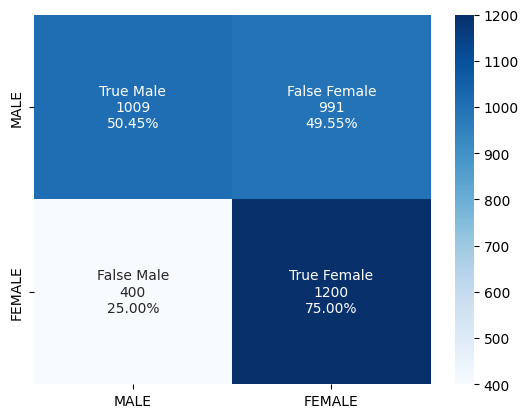

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id049.session02_split_name_sub-049_ses-02_desc-o_T2w/_run_None/sub-049_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id052.session02_split_name_sub-052_ses-02_desc-o_T2w/_run_None/sub-052_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id065.session02_split_name_sub-065_ses-02_desc-o_T2w/_run_None/sub-065_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id066.session02_split_name_sub-066_ses-02_desc-o_T2w/_run_None/sub-066_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6_up (InputLayer)        [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_7_front (InputLayer)     [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_8_left (InputLayer)      [(None, 65, 32, 42)  0           []                               
                                ]                                                           

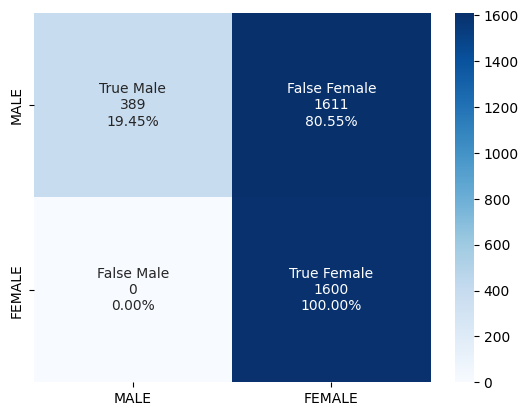

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id049.session02_split_name_sub-049_ses-02_desc-o_T2w/_run_None/sub-049_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id050.session02_split_name_sub-050_ses-02_desc-o_T2w/_run_None/sub-050_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id051.session02_split_name_sub-051_ses-02_desc-o_T2w/_run_None/sub-051_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id052.session02_split_name_sub-052_ses-02_desc-o_T2w/_run_None/sub-052_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_11_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_12_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

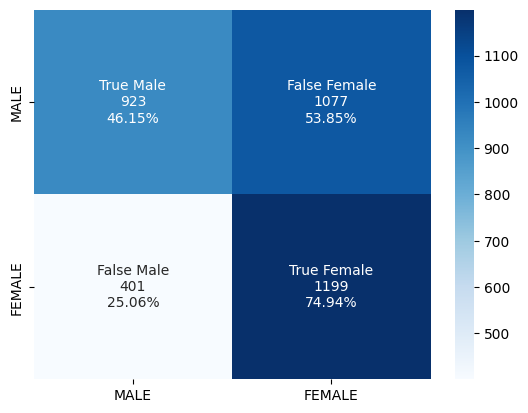

sub train:
['C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id049.session02_split_name_sub-049_ses-02_desc-o_T2w/_run_None/sub-049_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id050.session02_split_name_sub-050_ses-02_desc-o_T2w/_run_None/sub-050_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id051.session02_split_name_sub-051_ses-02_desc-o_T2w/_run_None/sub-051_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/preprocess_batch-001_rest/bold_datasink/commonspace_bold/_scan_info_subject_id065.session02_split_name_sub-065_ses-02_desc-o_T2w/_run_None/sub-065_ses-02_task-rest_desc-oa_bold_autobox_combined.nii.gz'
 'C:/Users/gdaalumno/Desktop/rabies/p

C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 32 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 65 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
C:\Users\gdaalumno\AppData\Local\anaconda3\envs\GPU_tf2.10_py3.10\lib\site-packages\keras\applications\vgg16.py:137: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 42 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14_up (InputLayer)       [(None, 42, 65, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_15_front (InputLayer)    [(None, 42, 32, 65)  0           []                               
                                ]                                                                 
                                                                                                  
 input_16_left (InputLayer)     [(None, 65, 32, 42)  0           []                               
                                ]                                                           

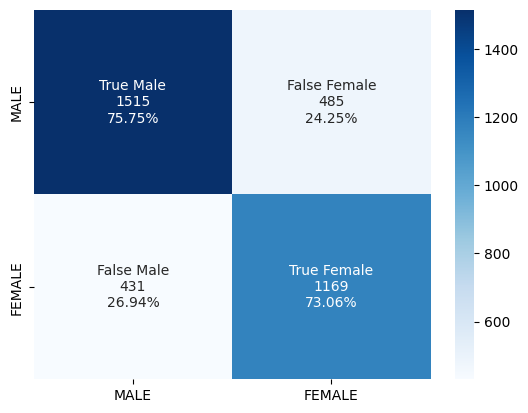

histories and scores from VGG 16 M2D


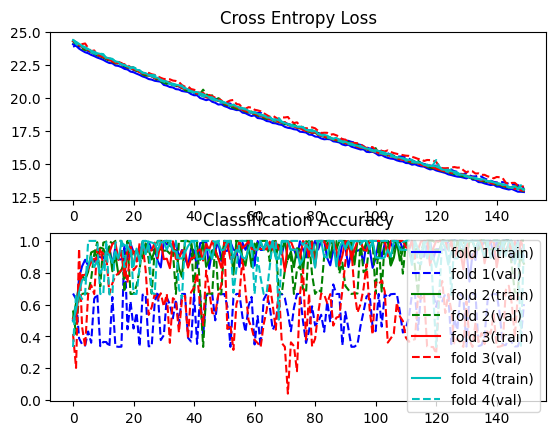

Accuracy: mean=62.528 std=7.277, n=4


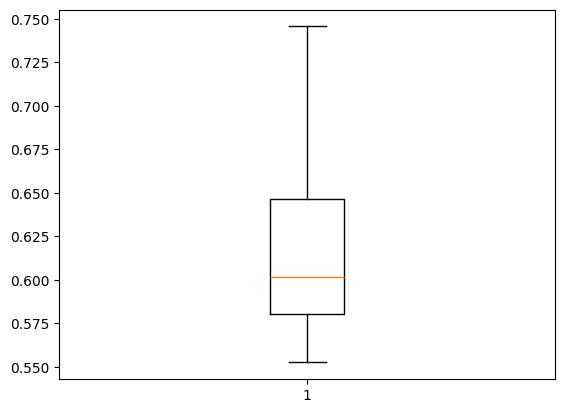

In [7]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores, histories = list(), list()
scores_cam, histories_cam = list(), list()


for train_ix, test_ix in kfold.split(subjects, labels):
    sub_train = subjects[list(train_ix)]
    y_train = labels[list(train_ix)]
  
    ext_x = np.append(subjects[list(test_ix)],np.array([1000]))
    ext_y = np.append(labels[list(test_ix)],np.array([0]))
    
    sub_test, sub_val, y_test, y_val  = train_test_split(ext_x, 
                                                         ext_y,
                                                         test_size=0.3, random_state=42,
                                                         stratify=ext_y)
    #Sujetos CPH con dos sesiones
    femaleCPHw1w7_train = []
    for i in range(len(sub_train)):
        if sub_train[i] in femaleCPHw1w7 and y_train[i] == 1:
            femaleCPHw1w7_train.append(sub_train[i])
           
    femaleCPHw1w7_test = []
    for i in range(len(sub_test)):
        if sub_test[i] in femaleCPHw1w7 and y_test[i] == 1:
            femaleCPHw1w7_test.append(sub_test[i])
     
    femaleCPHw1w7_val = []
    for i in range(len(sub_val)):
        if sub_val[i] in femaleCPHw1w7 and y_val[i] == 1:
            femaleCPHw1w7_val.append(sub_val[i])
    
    #Sujetos NAIVE tres sesiones
    femaleNaive3sess_train = []
    for i in sub_train:
        if i in femaleNaive3sess:
            femaleNaive3sess_train.append(i)
            
    femaleNaive3sess_test = []
    for i in sub_test:
        if i in femaleNaive3sess:
            femaleNaive3sess_test.append(i)
    
    femaleNaive3sess_val = []
    for i in sub_val:
        if i in femaleNaive3sess:
            femaleNaive3sess_val.append(i)
    
    #Sujetos CPH baseline
    femaleCPHBl_train = []
    for i in range(len(sub_train)):
        if sub_train[i] in femaleCPHbaseline and y_train[i] == 2:
            femaleCPHBl_train.append(sub_train[i])
            
    femaleCPHBl_test = []
    for i in range(len(sub_test)):
        if sub_test[i] in femaleCPHbaseline and y_test[i] == 2:
            femaleCPHBl_test.append(sub_test[i])
    
    femaleCPHBl_val = []
    for i in range(len(sub_val)):
        if sub_val[i] in femaleCPHbaseline and y_val[i] == 2:
            femaleCPHBl_val.append(sub_val[i])
    
    #CPH W1 and W7 (train, test, val)
    CPHTrain = FILES_and_LABELS(femaleCPHw1w7_train, [2,3], MRI_type, functional_type)
    CPHTest = FILES_and_LABELS(femaleCPHw1w7_test, [2,3], MRI_type, functional_type)
    CPHVal = FILES_and_LABELS(femaleCPHw1w7_val, [2,3], MRI_type, functional_type)
        
    CPH_train_path = CPHTrain.get_mask_and_bold()
    CPH_test_path = CPHTest.get_mask_and_bold()
    CPH_val_path = CPHVal.get_mask_and_bold()
    
    #NAIVE three sessions
    NAIVE3Train = FILES_and_LABELS(femaleNaive3sess_train, [1,2,3], MRI_type, functional_type)
    NAIVE3Test = FILES_and_LABELS(femaleNaive3sess_test, [1,2,3], MRI_type, functional_type)
    NAIVE3Val = FILES_and_LABELS(femaleNaive3sess_val, [1,2,3], MRI_type, functional_type)
        
    NAIVE3_train_path = NAIVE3Train.get_mask_and_bold()
    NAIVE3_test_path = NAIVE3Test.get_mask_and_bold()
    NAIVE3_val_path = NAIVE3Val.get_mask_and_bold()
    
    #CPH Session 1 Baseline
    BL_CPHTrain = FILES_and_LABELS(femaleCPHBl_train, [1], MRI_type, functional_type)
    BL_CPHTest = FILES_and_LABELS(femaleCPHBl_test, [1], MRI_type, functional_type)
    BL_CPHVal = FILES_and_LABELS(femaleCPHBl_val, [1], MRI_type, functional_type)
        
    BL_CPH_train_path = BL_CPHTrain.get_mask_and_bold()
    BL_CPH_test_path = BL_CPHTest.get_mask_and_bold()
    BL_CPH_val_path = BL_CPHVal.get_mask_and_bold()
        
    X_train = CPH_train_path+NAIVE3_train_path+BL_CPH_train_path
    X_test =  CPH_test_path+NAIVE3_test_path+BL_CPH_test_path
    X_val = CPH_val_path+NAIVE3_val_path+BL_CPH_val_path

    print("sub train:")
    print(np.array(X_train)[:,0])
    print("sub test:")
    print(np.array(X_test)[:,0])
    print("sub val:")
    print(np.array(X_val)[:,0])
    
    print("# sesiones CPH (W1 and W7) Train",len(CPH_train_path))
    print("# sesiones NAIVE (3 sessions) Train",len(NAIVE3_train_path))
    print("# sesiones CPH baseline Train",len(BL_CPH_train_path))

    print("# sesiones Train",len(X_train))
    print("# sesiones Test",len(X_test))
    print("# sesiones Val",len(X_val))    
    traingen = CustomDataGen(X_train, batch_size=4, format = "just_brain_M2D", vols = 400, num_class = 2, classes = "CPHvsNAIVEfemale")
    #Es necesario que la division entre X_test y batch_size tenga un modulo igual a 0. De otra manera el ultimo batch no lo utiliza al utilizar .predict
    testgen  = CustomDataGen(X_test, batch_size=1, format = "just_brain_M2D", vols=400, num_class = 2, classes = "CPHvsNAIVEfemale")
    valgen  = CustomDataGen(X_val, batch_size=len(X_val), format = "just_brain_M2D",vols=400, num_class = 2, classes = "CPHvsNAIVEfemale")
    
    #getting model 3D CNN
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)
    print("Starting VGG 16 M2D-----------------------------------------------------")
    CNN = VGG16_cnn2d_method()
    #CNN.compile(loss=tf.nn.softmax_cross_entropy_with_logits, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    #                metrics=["Accuracy"])
    
    start_time = datetime.now()
    
    print("Training")
    #history = CNN.fit(traingen, epochs=50, validation_data = valgen, shuffle=True)

    #Fine tuning
    # Unfreeze the base model
    CNN.trainable = True

    print("starting fine tuning")
    CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = .00001),  # Very low learning rate
                loss=tf.nn.softmax_cross_entropy_with_logits,
                metrics=["Accuracy"])
    history = CNN.fit(traingen, epochs=150, validation_data=valgen, shuffle=True)

    end_time = datetime.now()
    print('Duration (CNN): {}'.format(end_time - start_time))

    y_test=[]
    for i in range(int(len(X_test)/1)):
        x,y = testgen[i]
        y_test.extend(y)
    y_test = np.argmax(y_test, axis=1)
    
    print("predicts CNN")
    preds = tf.cast(tf.argmax(CNN.predict(testgen), axis=1), tf.int32)
    
    print("evaluating CNN")
    _,acc = CNN.evaluate(testgen, verbose=1)
    
    scores.append(acc)
    histories.append(history)
    
    print("CM CNN")
    confusionmatrix(y_test, preds)

print("histories and scores from VGG 16 M2D") 
summarize_diagnostics(histories)
summarize_performance(scores)